In [10]:
import pandas as pd
import dataframe_image as dfi
import os
import urllib.request
import gzip

## Import data

In [4]:
df_nodes_genes = pd.read_csv('../processed_data/nodes_genes.csv')

# Edges: Protein-Gene Connection
File from: https://www.ensembl.org/biomart/martview/

Ensembl Genes 112 > Human Genes (GRCh38.p14)

Protein - Gene Connections have these information:
* Gene ID
* Protein ID

In [5]:
df_edges_protein_gene = pd.read_csv('../import_data/ENSEMBLE/biomart_gene_protein.txt',  sep='\t')
df_edges_protein_gene.rename(columns={'Gene stable ID': 'Gene ID', 'Protein stable ID': 'Protein ID'}, inplace=True)

print(f"There are {len(df_edges_protein_gene)} rows in the imported dataset.")

There are 185330 rows in the imported dataset.


In [6]:
# drop genes without gene or protein
df_edges_protein_gene.dropna(inplace=True)

# filter for genes in nodes
df_edges_protein_gene = df_edges_protein_gene[df_edges_protein_gene['Gene ID'].isin(df_nodes_genes['Gene ID'])]


print(f"There are {len(df_edges_protein_gene)} rows in the filtered dataset.")
df_edges_protein_gene.head(10)

There are 101731 rows in the filtered dataset.


,Gene ID,Protein ID
5,ENSG00000198888,ENSP00000354687
9,ENSG00000198763,ENSP00000355046
15,ENSG00000198804,ENSP00000354499
18,ENSG00000198712,ENSP00000354876
20,ENSG00000228253,ENSP00000355265
21,ENSG00000198899,ENSP00000354632
22,ENSG00000198938,ENSP00000354982
24,ENSG00000198840,ENSP00000355206
26,ENSG00000212907,ENSP00000354728
27,ENSG00000198886,ENSP00000354961


# Edges: Protein-Protein Interaction
loaded from STRING database

Protein - Protein Interaction have these information:
* left Protein ID
* right Protein ID

In [11]:
# download STRING dataset
url_string = "https://stringdb-downloads.org/download/protein.links.full.v12.0/9606.protein.links.full.v12.0.txt.gz"

zip_file_name = "../import_data/STRING/protein.links.full.v12.0.txt.gz"

file_name = "../import_data/STRING/protein.links.full.v12.0.txt"

os.makedirs("../import_data/STRING", exist_ok=True)

if not os.path.exists(zip_file_name):
    urllib.request.urlretrieve(url_string, zip_file_name)

if not os.path.exists(file_name):
    with gzip.open(zip_file_name, 'rb') as f_in:
        with open(file_name, 'wb') as f_out:
            f_out.write(f_in.read())

In [5]:
df_edges_protein = pd.read_csv(file_name, sep=' ', usecols=[0, 1])

print('Length of STRING Links Dataset: ', len(df_edges_protein))

df_edges_protein.rename(columns={'protein1': 'left Protein ID', 'protein2': 'right Protein ID'}, inplace=True)

df_edges_protein['left Protein ID'] = df_edges_protein['left Protein ID'].apply(lambda x: x.split('.')[1])
df_edges_protein['right Protein ID'] = df_edges_protein['right Protein ID'].apply(lambda x: x.split('.')[1])

print(f"There are {len(df_edges_protein)} rows in the dataset.")
df_edges_protein.head()

Length of STRING Links Dataset:  13715404
There are 13715404 rows in the dataset.


,left Protein ID,right Protein ID
0,ENSP00000000233,ENSP00000356607
1,ENSP00000000233,ENSP00000427567
2,ENSP00000000233,ENSP00000253413
3,ENSP00000000233,ENSP00000493357
4,ENSP00000000233,ENSP00000324127


### Filter for Proteins from Nodes
Leads to only direct connections between proteins that are connected to genes

→ Gene - Protein - Protein - Gene


But we also want to include proteins that are not connected to a gene

→ Gene - Protein - $Protein$ - Protein - Gene


In [6]:
"""df_edges_protein = df_edges_protein[df_edges_protein['protein1'].isin(df_nodes_protein)]
df_edges_protein = df_edges_protein[df_edges_protein['protein2'].isin(df_nodes_protein)]

df_edges_protein"""

"df_edges_protein = df_edges_protein[df_edges_protein['protein1'].isin(df_nodes_protein)]\ndf_edges_protein = df_edges_protein[df_edges_protein['protein2'].isin(df_nodes_protein)]\n\ndf_edges_protein"

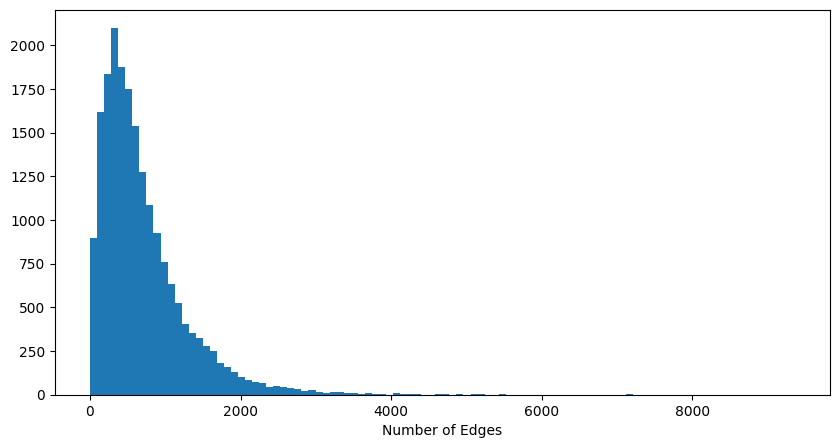

In [7]:
# number of edges per gene
import matplotlib.pyplot as plt
edge_per_gene = df_edges_protein.groupby('left Protein ID').count().sort_values('right Protein ID', ascending=False)

# hist plot
plt.figure(figsize=(10, 5))
plt.hist(edge_per_gene['right Protein ID'], bins=100)
plt.xlabel('Number of Edges')

plt.show()

# Nodes: Protein
Protein Nodes have these information:
* Protein ID


In [8]:
# Proteins that are connected to genes
df_nodes_protein1 = df_edges_protein_gene.copy()
df_nodes_protein1 = df_nodes_protein1['Protein ID']

df_nodes_protein1 = df_nodes_protein1.drop_duplicates().reset_index(drop=True)

df_nodes_protein1

0         ENSP00000354687
1         ENSP00000355046
2         ENSP00000354499
3         ENSP00000354876
4         ENSP00000355265
               ...       
101726    ENSP00000373370
101727    ENSP00000355866
101728    ENSP00000483812
101729    ENSP00000482935
101730    ENSP00000480008
Name: Protein ID, Length: 101731, dtype: object

In [9]:
# proteins that are connected to other proteins
df_nodes_protein2 = pd.concat([df_edges_protein['left Protein ID'], df_edges_protein['right Protein ID']], ignore_index=True)
df_nodes_protein2 = df_nodes_protein2.drop_duplicates().reset_index(drop=True)
df_nodes_protein2.rename('Protein ID', inplace=True)

df_nodes_protein2

0        ENSP00000000233
1        ENSP00000000412
2        ENSP00000001008
3        ENSP00000001146
4        ENSP00000002125
              ...       
19617    ENSP00000501254
19618    ENSP00000501259
19619    ENSP00000501265
19620    ENSP00000501277
19621    ENSP00000501317
Name: Protein ID, Length: 19622, dtype: object

In [10]:
# combine both
df_nodes_protein = pd.concat([df_nodes_protein1, df_nodes_protein2], ignore_index=True)
df_nodes_protein = df_nodes_protein.drop_duplicates()

df_nodes_protein

0         ENSP00000354687
1         ENSP00000355046
2         ENSP00000354499
3         ENSP00000354876
4         ENSP00000355265
               ...       
121335    ENSP00000501085
121336    ENSP00000501088
121337    ENSP00000501092
121339    ENSP00000501111
121352    ENSP00000501317
Name: Protein ID, Length: 104235, dtype: object

# Export Data

In [11]:
df_nodes_protein.to_csv('../processed_data/nodes_protein.csv', index=False)
df_edges_protein.to_csv('../processed_data/edges_protein.csv', index=False)
df_edges_protein_gene.to_csv('../processed_data/edges_protein_gene.csv', index=False)

In [12]:
print(f"There are {len(df_nodes_protein)} Protein Nodes")
print(f"There are {len(df_edges_protein)} Protein-Protein Edges")
print(f"There are {len(df_edges_protein_gene)} Protein-Gene Edges")

There are 104235 Protein Nodes
There are 13715404 Protein-Protein Edges
There are 101731 Protein-Gene Edges


In [13]:
df_edges_protein_plot = df_edges_protein.reset_index(drop=True)
df_edges_protein_gene_plot = df_edges_protein_gene.reset_index(drop=True)
df_nodes_protein_plot = df_nodes_protein.reset_index(drop=True)

df_nodes_protein_plot
# lib cant plot single columns

0         ENSP00000354687
1         ENSP00000355046
2         ENSP00000354499
3         ENSP00000354876
4         ENSP00000355265
               ...       
104230    ENSP00000501085
104231    ENSP00000501088
104232    ENSP00000501092
104233    ENSP00000501111
104234    ENSP00000501317
Name: Protein ID, Length: 104235, dtype: object

In [1]:
dfi.export(df_edges_protein_plot.head(5), '../tex/figures/03_02_protein_edges.png')
dfi.export(df_edges_protein_gene_plot.head(5), '../tex/figures/03_02_gene_protein_edges.png')
dfi.export(df_nodes_protein_plot.head(5), '../tex/figures/03_02_protein_nodes.png')

NameError: name 'dfi' is not defined